In [ ]:
# Import all packages here
import numpy as np
import pandas as pd

!pip install kagglehub
import kagglehub
import os

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder

!pip install tensorflow
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, Dropout, MaxPooling2D, BatchNormalization
from tensorflow.python.keras.engine import data_adapter

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from PIL import Image
%matplotlib inline


###Exploratory Data Analysis

In [ ]:
# Download latest version
kaggle_path = kagglehub.dataset_download("noamsegal/affectnet-training-data") + '/'
print("Path to dataset files:", kaggle_path)

# Import the labels.csv file as our dataset
df = pd.read_csv(kaggle_path+"/labels.csv")


100%|██████████| 314M/314M [00:02<00:00, 124MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/noamsegal/affectnet-training-data/versions/3/


In [ ]:
df

,Unnamed: 0,pth,label,relFCs
0,0,anger/image0000006.jpg,surprise,0.873142
1,1,anger/image0000060.jpg,anger,0.852311
2,2,anger/image0000061.jpg,anger,0.800957
3,3,anger/image0000066.jpg,disgust,0.843079
4,4,anger/image0000106.jpg,anger,0.849108
...,...,...,...,...
28170,28170,surprise/image0034960.jpg,surprise,0.825263
28171,28171,surprise/image0034961.jpg,surprise,0.738646
28172,28172,surprise/image0034966.jpg,surprise,0.774524
28173,28173,surprise/image0034973.jpg,neutral,0.766952


In [ ]:
# Define each unique emotion
labels = df['label'].unique()

def get_classes_distribution(df):
  """
  Prints the distribution of classes (labels) in a given DataFrame.

  This function calculates and displays the count and percentage of samples
  for each unique class (label) in the specified DataFrame. It assumes the
  DataFrame contains a column named 'label' representing the target variable.

  Args:
      df (pd.DataFrame): The input DataFrame containing the 'label' column.

  Returns:
      None: This function prints the class distribution but does not return
            any value.
  """

  # Get count for each label
  label_count = df['label'].value_counts()

  # Get total number of samples
  total_samples = len(df)

  # Count the number of items in each class
  for i in range(len(label_count)):
    label = label_count.index[i]
    count = label_count.values[i]
    percent = ((count / total_samples) * 100).round(2)
    print("{:<20s}: {} or {}%".format(label, count, percent))

In [ ]:
get_classes_distribution(df)

surprise            : 4616 or 16.38%
happy               : 4336 or 15.39%
anger               : 3608 or 12.81%
disgust             : 3472 or 12.32%
contempt            : 3244 or 11.51%
fear                : 3043 or 10.8%
sad                 : 2995 or 10.63%
neutral             : 2861 or 10.15%


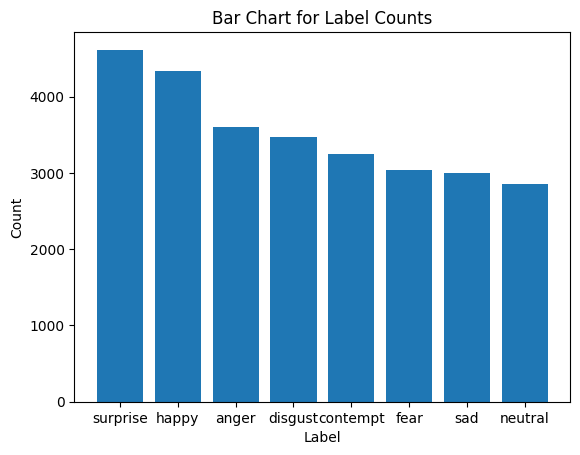

<Figure size 1000x600 with 0 Axes>

In [ ]:
"""
Display bar chart for distribution of labels.
"""

# Count occurences of each label
label_counts = df['label'].value_counts()

# Plot the number of each labels
plt.bar(label_counts.index, label_counts.values)
plt.xlabel('Label')
plt.ylabel('Count')
plt.title('Bar Chart for Label Counts')
plt.figure(figsize=(10, 6))
plt.tight_layout()
plt.show()

We can see the percentage/distribution of each emotion in the dataset.

In [ ]:
def display_images(df, emotions):
  """
  Displays a grid of sample images, one for each emotion, from the dataset.

  This function selects one image per emotion from the DataFrame and displays
  them in a grid layout. Each image is accompanied by its corresponding label
  (emotion) as the title of the subplot.

  Args:
      df (pd.DataFrame): The input DataFrame containing image paths and labels.
          It must include columns 'label' (emotion) and 'pth' (image path).
      emotions (list): A list of emotion labels present in the dataset.

  Returns:
      None: This function displays the images but does not return any value.
  """

  # Select one image per emotion
  df_sample = df.groupby('label').first().reset_index()

  fig, axs = plt.subplots(2, 4, sharey=True, num=None,
                        figsize=(5, 5), dpi=80, edgecolor='k')
  fig.suptitle("Sample Faces and Labels")
  axs = axs.flatten()

  for idx, (ax, row) in enumerate(zip(axs, df_sample.iterrows())):
    _, row = row  # Unpack index and row
    image_path = kaggle_path + row['pth']
    image = mpimg.imread(image_path)
    ax.imshow(image)
    ax.set_title(row['label'])
    ax.axis('off')

  plt.tight_layout()
  plt.show()

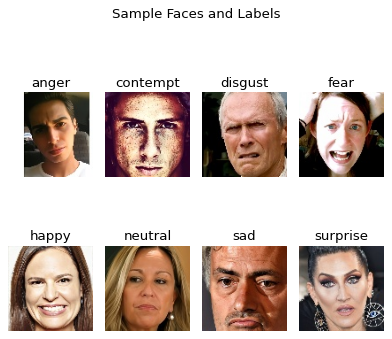

In [ ]:
display_images(df, labels)

###Data Preprocessing

In [ ]:
def add_img_dim(df):
  """
  Adds a new column to the DataFrame containing the dimensions (width, height)
  of each image based on its file path.

  Args:
      df (pd.DataFrame): A DataFrame with an image file path column named 'pth'.
                          Each path points to an image file.
  Raises:
      ValueError: If an image's dimensions are not (96, 96).

  Returns:
      None: Modifies the input DataFrame in place by adding a new column 'image_size',
            which contains a tuple of (width, height) for each image.

  Notes:
      - The function uses the Python Imaging Library (PIL) to read image dimensions.
      - Ensure that the paths in 'pth' are valid and accessible from the provided
        `kaggle_path` directory.
  """

  image_size = []

  # Loop through each image path to get its dimensions
  for path in df['pth']:
      with Image.open(kaggle_path + path) as img:
        width, height = img.size
        image_size.append((width, height))

  # Add the dimensions as a new column to df_train
  df['image_size'] = image_size

In [ ]:
add_img_dim(df)
df

,Unnamed: 0,pth,label,relFCs,image_size
0,0,anger/image0000006.jpg,surprise,0.873142,"(96, 96)"
1,1,anger/image0000060.jpg,anger,0.852311,"(96, 96)"
2,2,anger/image0000061.jpg,anger,0.800957,"(96, 96)"
3,3,anger/image0000066.jpg,disgust,0.843079,"(96, 96)"
4,4,anger/image0000106.jpg,anger,0.849108,"(96, 96)"
...,...,...,...,...,...
28170,28170,surprise/image0034960.jpg,surprise,0.825263,"(96, 96)"
28171,28171,surprise/image0034961.jpg,surprise,0.738646,"(96, 96)"
28172,28172,surprise/image0034966.jpg,surprise,0.774524,"(96, 96)"
28173,28173,surprise/image0034973.jpg,neutral,0.766952,"(96, 96)"


After adding the image_size column, we see each image has the same shape of (96,96). Thus we don't need to resize our images due to their uniform shape.

In [ ]:
"""
Converts DataFrame data into NumPy arrays for model training.

Assumptions:
- The input DataFrame have the following structure:
  - The first column contains the target labels.
  - All other columns contain the features.

Steps:
1. Extracts feature data (all columns except the first) and converts them to NumPy arrays.
2. Extracts target labels (first column) and converts them to NumPy arrays.
3. Prints the shapes of the resulting training features (`x`) and target labels (`y`).

The resulting arrays will have the following shapes:
- x.shape == (number of rows in df, number of features).
- y.shape == (number of rows in df,).
"""

x = np.array(df.iloc[:, 1:])
y = np.array(df.loc[:, 'label'])

print("x shape:", x.shape,
      "y shape:", y.shape)

x shape: (28175, 4) y shape: (28175,)


In [ ]:
def reshape_img_data(df, x):
  """
  Reshapes image data from file paths into a NumPy array of pixel data.

  Args:
      df (pd.DataFrame): DataFrame containing a column 'pth' with file paths
                          to the images.
      x (np.ndarray): A placeholder variable for the resulting NumPy array.
                      This parameter is overwritten during execution.

  Returns:
      np.ndarray: A NumPy array containing pixel data for all images in the DataFrame.
                  The array shape is (num_images, height, width, channels), where:
                  - `num_images` is the number of rows in the DataFrame.
                  - `height` and `width` are the dimensions of the images.
                  - `channels` is the number of color channels (3 for RGB).

  Notes:
      - Images are converted to RGB format regardless of their original color space.
      - Ensure all images are of consistent size before running this function, or it will raise errors.
      - Prints the shape of the resulting array for verification.
  """

  image_data = []

  # Loop through image paths and load pixel data
  for path in df['pth']:
    with Image.open(kaggle_path + path) as img:
      # Convert to RGB or grayscale depending on the image
      img = img.convert('RGB')
      # Append image as an array
      image_data.append(np.array(img))

  # Convert list to array
  x = np.array(image_data)

  # Check the shape of the array
  print("shape of x:", x.shape)
  return x

In [ ]:
x = reshape_img_data(df, x)

shape of x: (28175, 96, 96, 3)


Due to x's shape having a 3 in the last dimension, this means it has 3 color channels, RGB.

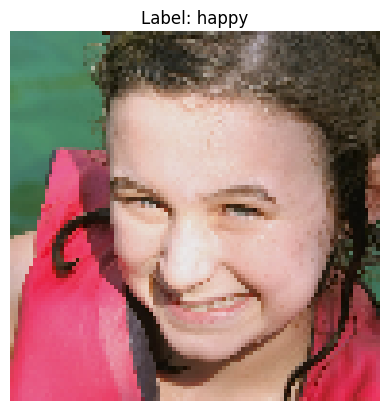

In [ ]:
# Choose a random image index
idx = np.random.randint(len(x))

# Display the image and its corresponding label
plt.imshow(x[idx])
plt.title(f"Label: {y[idx]}")
plt.axis('off')
plt.show()

After the image is reshaped to an array with the pixel data, we can now show individual images from the training or test sets.

In [ ]:
"""
Normalizes the pixel values of the image data.

This step rescales the pixel values from the range [0, 255] to [0, 1] by converting
the pixel values to `float32` and dividing by 255. This is commonly done in image
preprocessing before feeding the data into a neural network, particularly convolutional
neural networks (CNNs), to help the model learn faster and avoid large gradient values.
"""
x = x.astype('float32') / 255

In [ ]:
"""
Splits the training data into training and validation sets, performs one-hot
encoding on the labels,and prints the shapes of the resulting datasets.

1. Train-Test-Val Split:
   - The function splits the `x` and `y` data into a new training
      set and test set using an 80-20 split, then splits the 'x_train' and
      'y_train' data into a new training and validation set using the same split.
   - A fixed `random_state` is used for reproducibility.

2. One-Hot Encoding:
   - The labels (`y_train`, `y_val`, `y_test`) are one-hot encoded using
      TensorFlow's `to_categorical` function.
   - This is necessary for multi-class classification, where the output of the
      model corresponds to the probability distribution over multiple classes.
"""
x_train, x_test, y_train, y_test = train_test_split(x, y,
                                          test_size=0.2, random_state=42)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train,
                                          test_size=0.2, random_state=42)

num_classes = len(np.unique(y_train))

# One-hot encode the labels
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_val = label_encoder.transform(y_val)
y_test = label_encoder.transform(y_test)

y_train = tf.keras.utils.to_categorical(y_train, num_classes)
y_val = tf.keras.utils.to_categorical(y_val, num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes)

# Check the shapes of the new datasets
print("x_train shape:", x_train.shape, "x_val shape:", x_val.shape,
      "x_test shape:", x_test.shape, "y_train shape:", y_train.shape,
      "y_val shape:", y_val.shape)

x_train shape: (18032, 96, 96, 3) x_val shape: (4508, 96, 96, 3) x_test shape: (5635, 96, 96, 3) y_train shape: (18032, 8) y_val shape: (4508, 8)


In [ ]:

model = models.Sequential([

    # 1st Conv Block
    layers.Conv2D (filters =32, kernel_size =3, strides = 1, padding ='same', activation='relu'),
    layers.BatchNormalization(axis=-1),
    layers.Conv2D (filters =32, kernel_size =3, strides = 1, padding ='same', activation='relu'),
    layers.BatchNormalization(axis=-1),
    layers.Conv2D (filters =32, kernel_size =3, strides = 1, padding ='same', activation='relu'),
    layers.BatchNormalization(axis=-1),
    layers.MaxPool2D(pool_size =2, strides =2, padding ='same'),
    layers.Dropout(0.25),

    # 2nd Conv Block
    layers.Conv2D (filters =64, kernel_size =3, strides = 1, padding ='same', activation='relu'),
    layers.BatchNormalization(axis=-1),
    layers.Conv2D (filters =64, kernel_size =3, strides = 1, padding ='same', activation='relu'),
    layers.BatchNormalization(axis=-1),
    layers.Conv2D (filters =64, kernel_size =3, strides = 1, padding ='same', activation='relu'),
    layers.BatchNormalization(axis=-1),
    layers.MaxPool2D(pool_size =2, strides =2, padding ='same'),
    layers.Dropout(0.25),

    # 3rd Conv Block
    layers.Conv2D (filters =128, kernel_size =3, strides = 1, padding ='same', activation='relu'),
    layers.BatchNormalization(axis=-1),
    layers.Conv2D (filters =128, kernel_size =3, strides = 1, padding ='same', activation='relu'),
    layers.BatchNormalization(axis=-1),
    layers.Conv2D (filters =128, kernel_size =3, strides = 1, padding ='same', activation='relu'),
    layers.MaxPool2D(pool_size =2, strides =2, padding ='same'),
    layers.Dropout(0.25),


    # 4th Conv block
    layers.Conv2D (filters =256, kernel_size =3, strides = 1 , padding ='same', activation='relu'),
    layers.BatchNormalization(axis=-1),
    layers.Conv2D (filters =256, kernel_size =3, strides = 1, padding ='same', activation='relu'),
    layers.BatchNormalization(axis=-1),
    layers.Conv2D (filters =256, kernel_size =3, strides = 1, padding ='same', activation='relu'),
    layers.BatchNormalization(axis=-1),
    layers.MaxPool2D(pool_size =2, strides =2, padding ='same'),
    layers.Dropout(0.25),


    # Fully connected layers
    layers.Flatten(),
    layers.Dense(units = 1024, activation ='relu'),
    layers.Dense(units = 1024, activation ='relu'),
    layers.Dropout(0.5),
    layers.Dense(units = 8, activation ='softmax'),

])


In [ ]:
learning_rate = tf.Variable(0.001, trainable=False)
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
def _is_distributed_dataset(dataset):
    return isinstance(dataset, data_adapter.input_lib.DistributedDatasetSpec)

data_adapter._is_distributed_dataset = _is_distributed_dataset
history = model.fit(x_train, y_train, epochs=15, batch_size=32, validation_data=(x_val, y_val))

Epoch 1/15
564/564 ━━━━━━━━━━━━━━━━━━━━ 47s 44ms/step - accuracy: 0.1598 - loss: 3.8261 - val_accuracy: 0.3336 - val_loss: 1.7925
Epoch 2/15
564/564 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - accuracy: 0.3393 - loss: 1.7593 - val_accuracy: 0.3960 - val_loss: 1.6401
Epoch 3/15
564/564 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - accuracy: 0.4098 - loss: 1.5831 - val_accuracy: 0.3966 - val_loss: 1.6113
Epoch 4/15
564/564 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - accuracy: 0.4574 - loss: 1.4436 - val_accuracy: 0.4902 - val_loss: 1.3574
Epoch 5/15
564/564 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - accuracy: 0.5019 - loss: 1.3304 - val_accuracy: 0.4789 - val_loss: 1.4928
Epoch 6/15
564/564 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - accuracy: 0.5330 - loss: 1.2555 - val_accuracy: 0.5069 - val_loss: 1.3266
Epoch 7/15
564/564 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - accuracy: 0.5740 - loss: 1.1608 - val_accuracy: 0.5373 - val_loss: 1.2476
Epoch 8/15
564/564 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - accuracy: 0.5945 - loss: 1.1035 - val_acc

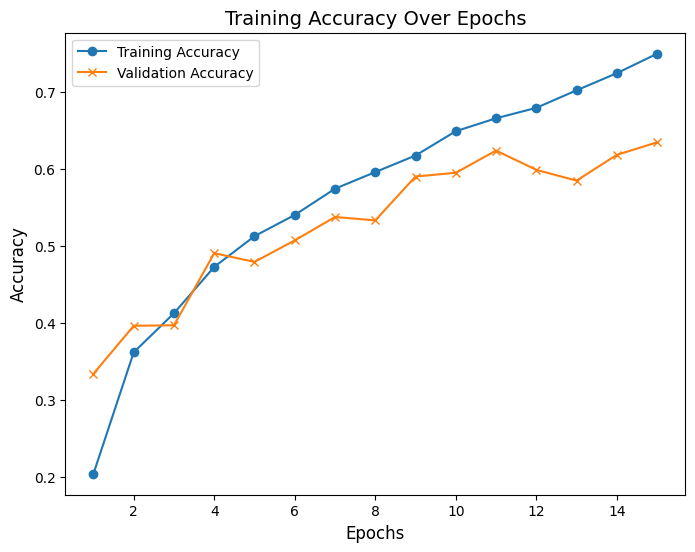

In [ ]:
# Extract accuracy and validation accuracy
training_accuracy = history.history['accuracy']
validation_accuracy = history.history['val_accuracy']
epochs = range(1, len(training_accuracy) + 1)  # Create a range for epochs

# Plot training and validation accuracy
plt.figure(figsize=(8, 6))
plt.plot(epochs, training_accuracy, label='Training Accuracy', marker='o')
plt.plot(epochs, validation_accuracy, label='Validation Accuracy', marker='x')
plt.title('Training Accuracy Over Epochs', fontsize=14)

plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.legend()
plt.show()


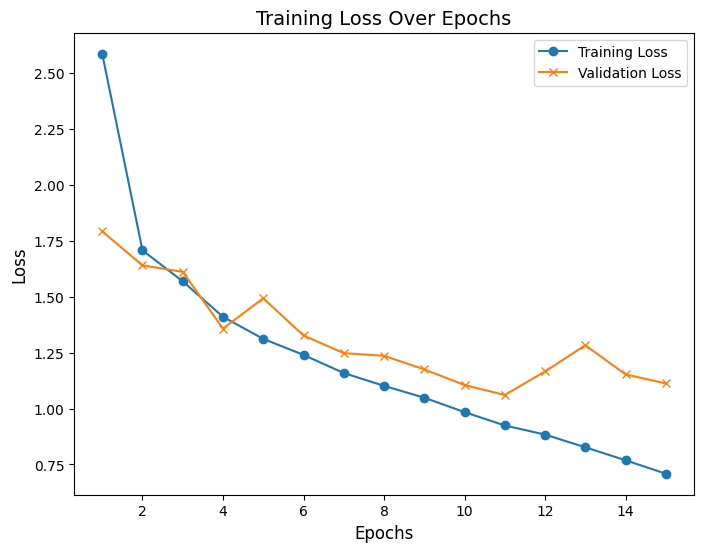

In [ ]:
# Extract accuracy and validation accuracy
training_accuracy = history.history['loss']
validation_accuracy = history.history['val_loss']
epochs = range(1, len(training_accuracy) + 1)  # Create a range for epochs

# Plot training and validation accuracy
plt.figure(figsize=(8, 6))
plt.plot(epochs, training_accuracy, label='Training Loss', marker='o')
plt.plot(epochs, validation_accuracy, label='Validation Loss', marker='x')
plt.title('Training Loss Over Epochs', fontsize=14)

plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.legend()
plt.show()


In [ ]:
test_loss, test_acc = model.evaluate(x_test, y_test)
labels_list = ['sad', 'disgust', 'angry', 'neutral', 'fear', 'surprise', 'happy', 'contempt']
y_pred = model.predict(x_test)
y_pred = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)
print(f"Test Accuracy: {test_acc}")
print(classification_report(y_true, y_pred, target_names=labels_list, digits=4))

177/177 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - accuracy: 0.6313 - loss: 1.1232
177/177 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step
Test Accuracy: 0.6253771185874939
              precision    recall  f1-score   support

         sad     0.6555    0.5677    0.6084       724
     disgust     0.5753    0.7099    0.6356       624
       angry     0.4705    0.7061    0.5647       677
     neutral     0.6054    0.6367    0.6206       600
        fear     0.8187    0.8657    0.8415       871
    surprise     0.6530    0.3360    0.4437       616
       happy     0.6812    0.3778    0.4860       622
    contempt     0.6091    0.6815    0.6433       901

    accuracy                         0.6254      5635
   macro avg     0.6336    0.6102    0.6055      5635
weighted avg     0.6394    0.6254    0.6176      5635

